In [1]:
from pathlib import Path
from multi_stage import SequentialStageOptimizer

# Setup paths
repo = Path("/Users/arnoclaude/Documents/TUM/Thesis/STRIDE")

# Notebook-specific output directory (in same folder as notebook)
notebook_output = repo / "notebooks" / "02_test_2_stage" / "output"
notebook_output.mkdir(exist_ok=True, parents=True)

print(f"✓ Output directory: {notebook_output}")
print()
print("Testing multi-stage optimizer with realistic CO2 constraints:")
print("  - CO2 limit: 500 kg (2025) → 420 kg (2030) [decarbonization pathway]")
print("  - Technology cost curves: PV -5%/yr, ESS -8%/yr")
print("  - Fleet demand growth: +10%/yr")
print("  - ESS size_existing: 0 Wh (no battery, must invest)")
print("  - Fleet size: 15 BEVs (3x original, growing demand)")
print("  - Grid size_existing: 0 W (must invest)")
print()

# Create 2-stage optimizer with REALISTIC test scenario
optimizer = SequentialStageOptimizer(
    stages=[2025, 2030],
    template_scenario_path=repo / "revoletion/example/scenarios_multi_stage_realistic.csv",
    settings_path=repo / "revoletion/example/settings.csv",
    revoletion_dir=repo / "revoletion",
    output_dir=notebook_output,
    scenario_column="multi_stage_test"
)

# Run it!
results = optimizer.optimize()

✓ Output directory: /Users/arnoclaude/Documents/TUM/Thesis/STRIDE/notebooks/02_test_2_stage/output

Testing multi-stage optimizer with realistic CO2 constraints:
  - CO2 limit: 500 kg (2025) → 420 kg (2030) [decarbonization pathway]
  - Technology cost curves: PV -5%/yr, ESS -8%/yr
  - Fleet demand growth: +10%/yr
  - ESS size_existing: 0 Wh (no battery, must invest)
  - Fleet size: 15 BEVs (3x original, growing demand)
  - Grid size_existing: 0 W (must invest)


STRIDE Sequential Multi-Stage Optimization
Stages: [2025, 2030]
Discount rate (WACC): 9.0%
Output directory: /Users/arnoclaude/Documents/TUM/Thesis/STRIDE/notebooks/02_test_2_stage/output


STAGE 1/2: Year 2025

1. Generating scenario for year 2025
  - Using scenario column: 'multi_stage_test'
  - CO2 limit: 500 kg
  - Stage duration: 5 years
  - CO2 limit: 500 kg → 500 kg (pathway baseline)
  ✓ Created scenario file: scenario_stage_2025.csv

2. Running REVOL-E-TION optimization
  - Command: /Users/arnoclaude/Documents/TUM/The

# Multi-Stage Optimization Analysis

This section provides comprehensive visualizations and analysis of the 2-stage sequential optimization results.

In [2]:
# Load results and setup plotting
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load results
with open(notebook_output / "multi_stage_results.json", 'r') as f:
    results = json.load(f)

# Create figures directory
fig_dir = notebook_output / "figures"
fig_dir.mkdir(exist_ok=True)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11

print("✓ Analysis setup complete")
print(f"✓ Results loaded from: {notebook_output / 'multi_stage_results.json'}")
print(f"✓ Figures will be saved to: {fig_dir}")

✓ Analysis setup complete
✓ Results loaded from: /Users/arnoclaude/Documents/TUM/Thesis/STRIDE/notebooks/02_test_2_stage/output/multi_stage_results.json
✓ Figures will be saved to: /Users/arnoclaude/Documents/TUM/Thesis/STRIDE/notebooks/02_test_2_stage/output/figures


## Infeasibility Check

Before analyzing results, let's check if any stages were infeasible:

In [3]:
# Check for infeasible stages
infeasible_stages = []
for year, stage_results in results.items():
    if stage_results.get('status') == 'infeasible':
        infeasible_stages.append(year)

if infeasible_stages:
    print("="*80)
    print("⚠️  WARNING: INFEASIBLE STAGES DETECTED")
    print("="*80)
    print(f"\nThe following stages were INFEASIBLE (no solution found):")
    for year in infeasible_stages:
        print(f"  • Stage {year}")
    print(f"\nPossible causes:")
    print(f"  • CO2 constraint too tight for available technologies")
    print(f"  • Insufficient capacity inherited from previous stage")
    print(f"  • Conflicting constraints (e.g., demand > max grid + PV + ESS)")
    print(f"\nSuggestions:")
    print(f"  • Relax CO2 limits in the decarbonization pathway")
    print(f"  • Reduce fleet growth rate")
    print(f"  • Check scenario constraints in template CSV")
    print("="*80)
else:
    print("✓ All stages completed successfully - no infeasibility detected")

✓ All stages completed successfully - no infeasibility detected


## Figure 1: Investment Timeline Overview

✓ Saved: fig1_investment_timeline.png


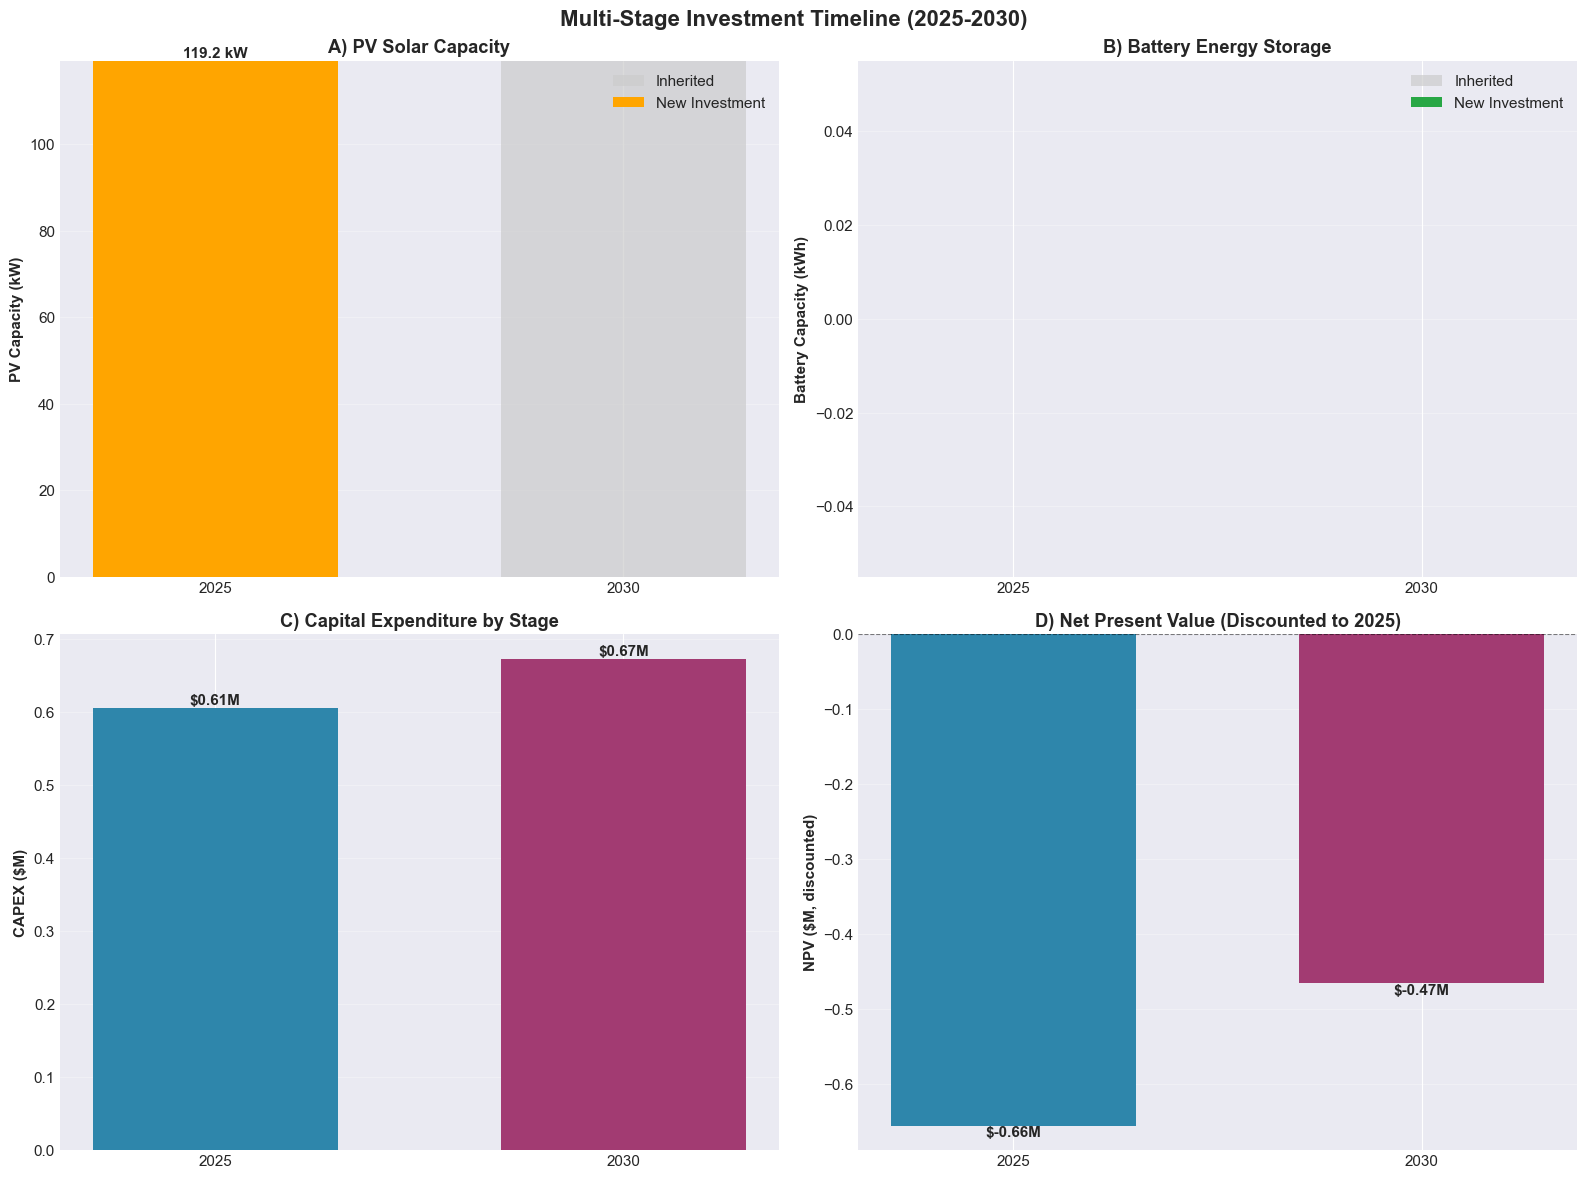

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Multi-Stage Investment Timeline (2025-2030)', fontsize=16, fontweight='bold')

stages = [2025, 2030]
colors = {'2025': '#2E86AB', '2030': '#A23B72'}
x = np.arange(len(stages))
width = 0.6

# ========== Plot 1: PV Capacity Evolution ==========
ax = axes[0, 0]
pv_total = [results['2025']['pv_size_total']/1000, results['2030']['pv_size_total']/1000]
pv_new = [results['2025']['pv_size_invest']/1000, results['2030']['pv_size_invest']/1000]
pv_existing = [0, results['2025']['pv_size_total']/1000]

ax.bar(x, pv_existing, width, label='Inherited', color='#cccccc', alpha=0.7)
ax.bar(x, pv_new, width, bottom=pv_existing, label='New Investment', color='#FFA500')
ax.set_ylabel('PV Capacity (kW)', fontweight='bold')
ax.set_title('A) PV Solar Capacity', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(stages)
ax.legend()
ax.grid(axis='y', alpha=0.3)

for i, (new, total) in enumerate(zip(pv_new, pv_total)):
    if new > 0:
        ax.text(i, total, f'{total:.1f} kW', ha='center', va='bottom', fontweight='bold')

# ========== Plot 2: Battery Capacity Evolution ==========
ax = axes[0, 1]
ess_total = [results['2025']['ess_size_total']/1000 if results['2025']['ess_size_total'] else 0,
             results['2030']['ess_size_total']/1000 if results['2030']['ess_size_total'] else 0]
ess_new = [results['2025']['ess_size_invest']/1000 if results['2025']['ess_size_invest'] else 0,
           results['2030']['ess_size_invest']/1000 if results['2030']['ess_size_invest'] else 0]
ess_existing = [0, results['2025']['ess_size_total']/1000 if results['2025']['ess_size_total'] else 0]

ax.bar(x, ess_existing, width, label='Inherited', color='#cccccc', alpha=0.7)
ax.bar(x, ess_new, width, bottom=ess_existing, label='New Investment', color='#28a745')
ax.set_ylabel('Battery Capacity (kWh)', fontweight='bold')
ax.set_title('B) Battery Energy Storage', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(stages)
ax.legend()
ax.grid(axis='y', alpha=0.3)

for i, (new, total) in enumerate(zip(ess_new, ess_total)):
    if total > 0:
        ax.text(i, total, f'{total:.1f} kWh', ha='center', va='bottom', fontweight='bold')

# ========== Plot 3: CAPEX by Stage ==========
ax = axes[1, 0]
capex_values = [results['2025']['capex_prj'], results['2030']['capex_prj']]
bars = ax.bar(x, [c/1e6 for c in capex_values], width, color=[colors['2025'], colors['2030']])
ax.set_ylabel('CAPEX ($M)', fontweight='bold')
ax.set_title('C) Capital Expenditure by Stage', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(stages)
ax.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:.2f}M', ha='center', va='bottom', fontweight='bold')

# ========== Plot 4: NPV by Stage (Discounted) ==========
ax = axes[1, 1]
npv_values = [results['2025']['npv_discounted'], results['2030']['npv_discounted']]
bars = ax.bar(x, [n/1e6 for n in npv_values], width, color=[colors['2025'], colors['2030']])
ax.set_ylabel('NPV ($M, discounted)', fontweight='bold')
ax.set_title('D) Net Present Value (Discounted to 2025)', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(stages)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
ax.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:.2f}M', ha='center', va='top' if height < 0 else 'bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(fig_dir / 'fig1_investment_timeline.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: fig1_investment_timeline.png")
plt.show()

## Figure 2: Environmental Impact

/var/folders/xs/wg5nnjfn69jggdk516wm0hz00000gn/T/ipykernel_22201/3969878546.py:58: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/xs/wg5nnjfn69jggdk516wm0hz00000gn/T/ipykernel_22201/3969878546.py:58: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/xs/wg5nnjfn69jggdk516wm0hz00000gn/T/ipykernel_22201/3969878546.py:59: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig(fig_dir / 'fig2_environmental_impact.png', dpi=300, bbox_inches='tight')
/var/folders/xs/wg5nnjfn69jggdk516wm0hz00000gn/T/ipykernel_22201/3969878546.py:59: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig(fig_dir / 'fig2_environmental_impact.png', dpi=300, bbox_inches='tight')


✓ Saved: fig2_environmental_impact.png


/Users/arnoclaude/Documents/TUM/Thesis/thesis-optimization/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/arnoclaude/Documents/TUM/Thesis/thesis-optimization/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


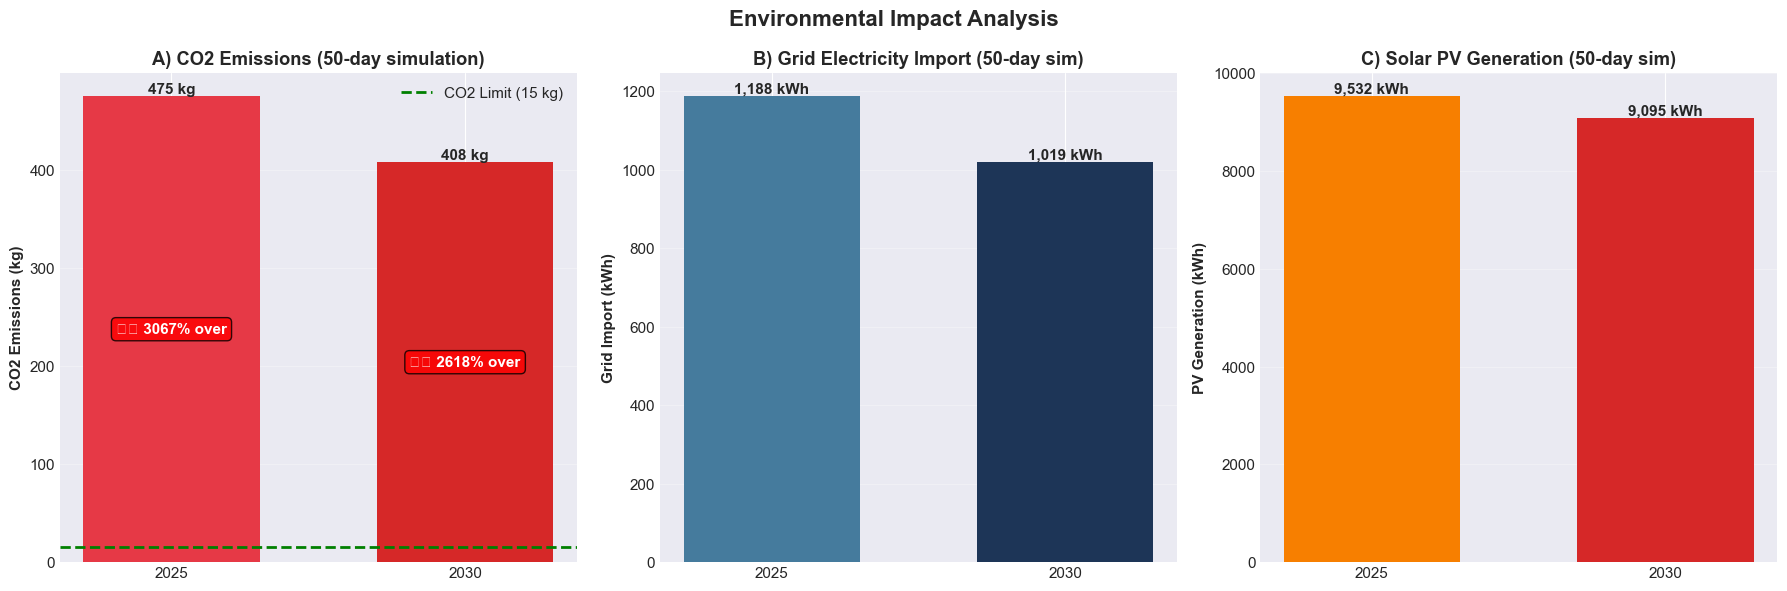

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Environmental Impact Analysis', fontsize=16, fontweight='bold')

# ========== Plot 1: CO2 Emissions ==========
ax = axes[0]
co2_values = [results['2025']['co2_sim_kg'], results['2030']['co2_sim_kg']]
co2_limit = 15  # kg
bars = ax.bar(x, co2_values, width, color=['#e63946', '#d62828'])
ax.axhline(y=co2_limit, color='green', linestyle='--', linewidth=2, label=f'CO2 Limit ({co2_limit} kg)')
ax.set_ylabel('CO2 Emissions (kg)', fontweight='bold')
ax.set_title('A) CO2 Emissions (50-day simulation)', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(stages)
ax.legend()
ax.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.0f} kg', ha='center', va='bottom', fontweight='bold')
    violation = (height / co2_limit - 1) * 100
    if violation > 0:
        ax.text(bar.get_x() + bar.get_width()/2., height * 0.5,
                f'⚠️ {violation:.0f}% over',
                ha='center', va='center', color='white', fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='red', alpha=0.8))

# ========== Plot 2: Grid Import Energy ==========
ax = axes[1]
grid_import = [results['2025']['grid_import_sim_kwh'], results['2030']['grid_import_sim_kwh']]
bars = ax.bar(x, grid_import, width, color=['#457b9d', '#1d3557'])
ax.set_ylabel('Grid Import (kWh)', fontweight='bold')
ax.set_title('B) Grid Electricity Import (50-day sim)', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(stages)
ax.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:,.0f} kWh', ha='center', va='bottom', fontweight='bold')

# ========== Plot 3: PV Generation ==========
ax = axes[2]
pv_gen = [results['2025']['pv_generation_sim_kwh'], results['2030']['pv_generation_sim_kwh']]
bars = ax.bar(x, pv_gen, width, color=['#f77f00', '#d62828'])
ax.set_ylabel('PV Generation (kWh)', fontweight='bold')
ax.set_title('C) Solar PV Generation (50-day sim)', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(stages)
ax.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:,.0f} kWh', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(fig_dir / 'fig2_environmental_impact.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: fig2_environmental_impact.png")
plt.show()

## Figure 3: Economic Analysis

✓ Saved: fig3_economic_analysis.png


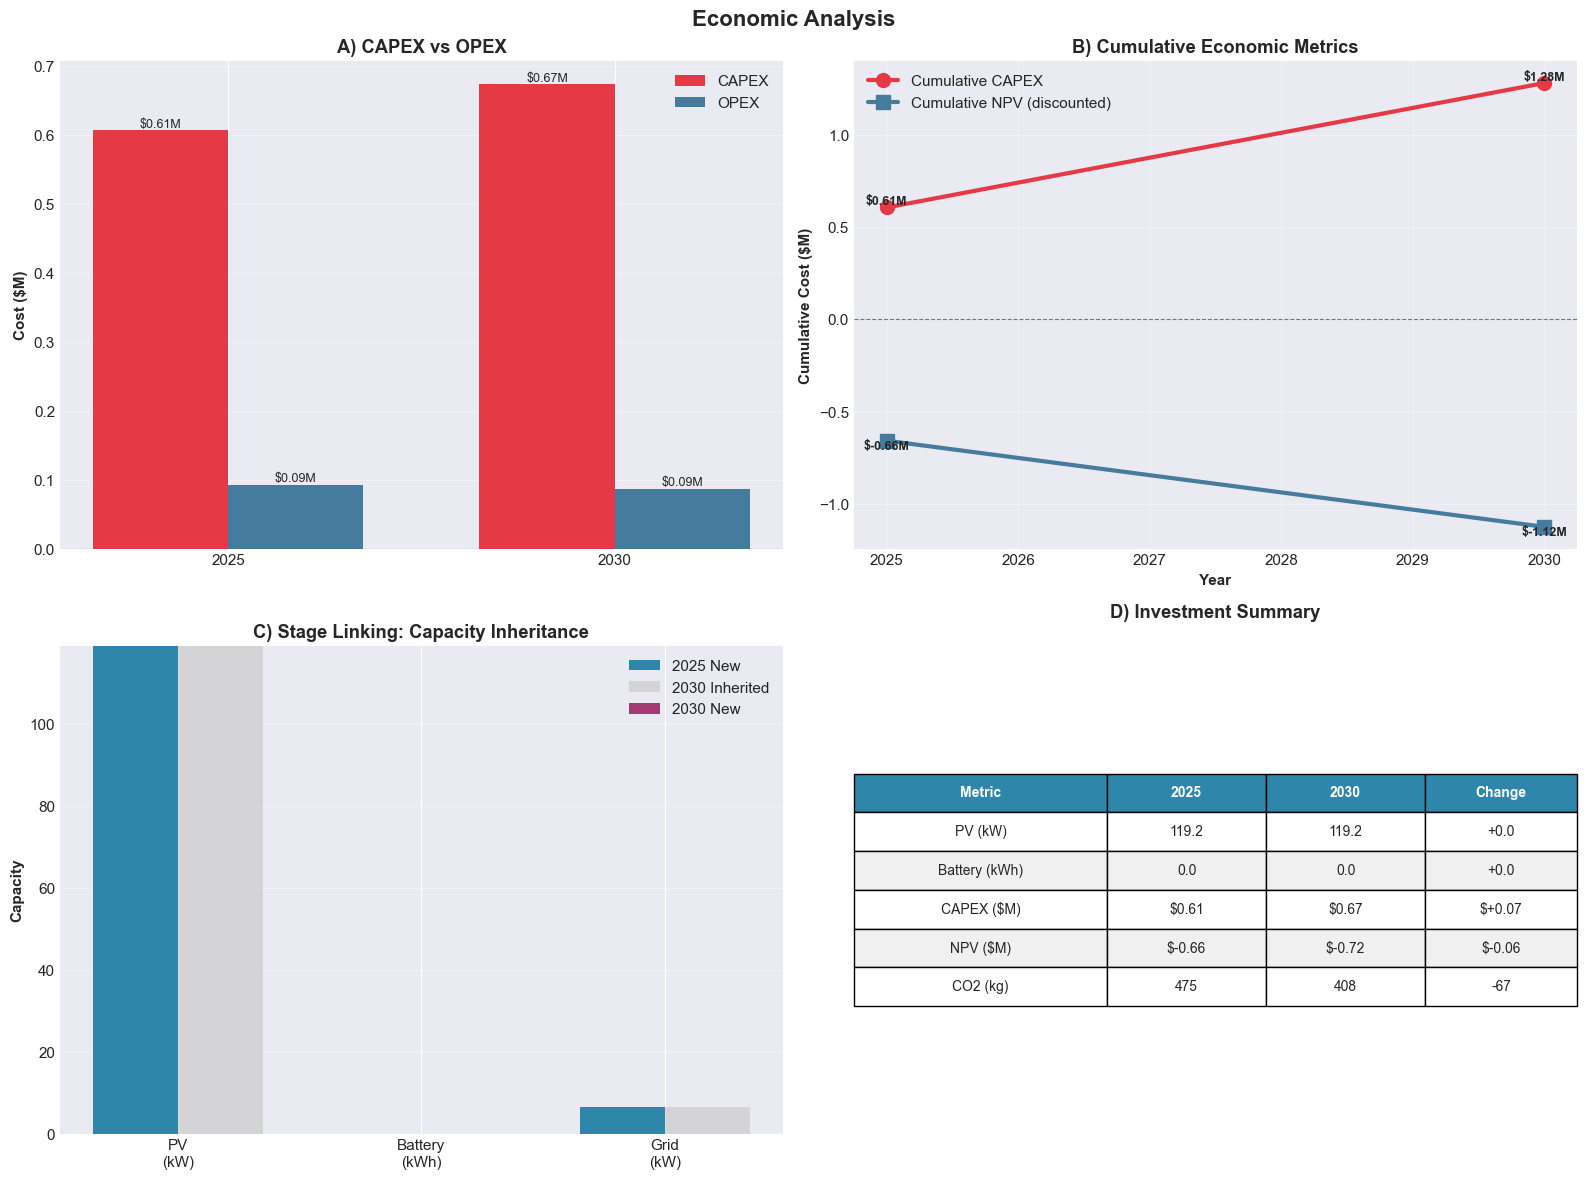

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Economic Analysis', fontsize=16, fontweight='bold')

# ========== Plot 1: CAPEX vs OPEX ==========
ax = axes[0, 0]
capex = [results['2025']['capex_prj']/1e6, results['2030']['capex_prj']/1e6]
opex = [results['2025']['opex_prj']/1e6, results['2030']['opex_prj']/1e6]

x_pos = np.arange(len(stages))
width_eco = 0.35

bars1 = ax.bar(x_pos - width_eco/2, capex, width_eco, label='CAPEX', color='#e63946')
bars2 = ax.bar(x_pos + width_eco/2, opex, width_eco, label='OPEX', color='#457b9d')

ax.set_ylabel('Cost ($M)', fontweight='bold')
ax.set_title('A) CAPEX vs OPEX', fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(stages)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:.2f}M', ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)

# ========== Plot 2: Cumulative Costs ==========
ax = axes[0, 1]
cumulative_capex = [capex[0], capex[0] + capex[1]]
cumulative_npv_disc = [results['2025']['npv_discounted']/1e6,
                       results['2025']['npv_discounted']/1e6 + results['2030']['npv_discounted']/1e6]

ax.plot([2025, 2030], cumulative_capex, marker='o', linewidth=3, markersize=10,
        label='Cumulative CAPEX', color='#e63946')
ax.plot([2025, 2030], cumulative_npv_disc, marker='s', linewidth=3, markersize=10,
        label='Cumulative NPV (discounted)', color='#457b9d')

ax.set_ylabel('Cumulative Cost ($M)', fontweight='bold')
ax.set_title('B) Cumulative Economic Metrics', fontweight='bold')
ax.set_xlabel('Year', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)

for year, capex_val, npv_val in zip([2025, 2030], cumulative_capex, cumulative_npv_disc):
    ax.text(year, capex_val, f'${capex_val:.2f}M', ha='center', va='bottom', fontweight='bold', fontsize=9)
    ax.text(year, npv_val, f'${npv_val:.2f}M', ha='center', va='top', fontweight='bold', fontsize=9)

# ========== Plot 3: Stage Linking Visualization ==========
ax = axes[1, 0]
# Show capacity inherited vs new for each stage
categories = ['PV\n(kW)', 'Battery\n(kWh)', 'Grid\n(kW)']
x_cat = np.arange(len(categories))
width_cat = 0.35

# 2025 (all new, no inherited)
new_2025 = [
    results['2025']['pv_size_invest']/1000 if results['2025']['pv_size_invest'] else 0,
    results['2025']['ess_size_invest']/1000 if results['2025']['ess_size_invest'] else 0,
    results['2025']['grid_size_g2s']/1000
]

# 2030 (inherited + new)
inherited_2030 = [
    results['2025']['pv_size_total']/1000,
    results['2025']['ess_size_total']/1000 if results['2025']['ess_size_total'] else 0,
    results['2025']['grid_size_g2s']/1000
]
new_2030 = [
    results['2030']['pv_size_invest']/1000 if results['2030']['pv_size_invest'] else 0,
    results['2030']['ess_size_invest']/1000 if results['2030']['ess_size_invest'] else 0,
    results['2030']['grid_size_g2s']/1000 - results['2025']['grid_size_g2s']/1000
]

bars1 = ax.bar(x_cat - width_cat/2, new_2025, width_cat, label='2025 New', color='#2E86AB')
bars2 = ax.bar(x_cat + width_cat/2, inherited_2030, width_cat, label='2030 Inherited', color='#cccccc', alpha=0.7)
bars3 = ax.bar(x_cat + width_cat/2, new_2030, width_cat, bottom=inherited_2030, label='2030 New', color='#A23B72')

ax.set_ylabel('Capacity', fontweight='bold')
ax.set_title('C) Stage Linking: Capacity Inheritance', fontweight='bold')
ax.set_xticks(x_cat)
ax.set_xticklabels(categories)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# ========== Plot 4: Investment Summary Table ==========
ax = axes[1, 1]
ax.axis('off')

# Create summary table data
table_data = [
    ['Metric', '2025', '2030', 'Change'],
    ['PV (kW)', f"{results['2025']['pv_size_total']/1000:.1f}",
     f"{results['2030']['pv_size_total']/1000:.1f}",
     f"+{(results['2030']['pv_size_total']-results['2025']['pv_size_total'])/1000:.1f}"],
    ['Battery (kWh)', 
     f"{results['2025']['ess_size_total']/1000:.1f}" if results['2025']['ess_size_total'] else "0.0",
     f"{results['2030']['ess_size_total']/1000:.1f}" if results['2030']['ess_size_total'] else "0.0",
     f"+{((results['2030']['ess_size_total'] or 0)-(results['2025']['ess_size_total'] or 0))/1000:.1f}"],
    ['CAPEX ($M)', f"${results['2025']['capex_prj']/1e6:.2f}",
     f"${results['2030']['capex_prj']/1e6:.2f}",
     f"${(results['2030']['capex_prj']-results['2025']['capex_prj'])/1e6:+.2f}"],
    ['NPV ($M)', f"${results['2025']['npv']/1e6:.2f}",
     f"${results['2030']['npv']/1e6:.2f}",
     f"${(results['2030']['npv']-results['2025']['npv'])/1e6:+.2f}"],
    ['CO2 (kg)', f"{results['2025']['co2_sim_kg']:.0f}",
     f"{results['2030']['co2_sim_kg']:.0f}",
     f"{results['2030']['co2_sim_kg']-results['2025']['co2_sim_kg']:+.0f}"],
]

table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                colWidths=[0.35, 0.22, 0.22, 0.21])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style header row
for i in range(4):
    table[(0, i)].set_facecolor('#2E86AB')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(table_data)):
    for j in range(4):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')

ax.set_title('D) Investment Summary', fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(fig_dir / 'fig3_economic_analysis.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: fig3_economic_analysis.png")
plt.show()

## Summary Statistics

In [7]:
# Create comprehensive summary table
summary_data = {
    'Metric': [
        'PV Capacity (kW)',
        'Battery Capacity (kWh)',
        'Grid Connection (kW)',
        'CAPEX ($M)',
        'OPEX ($M)',
        'NPV ($M)',
        'NPV Discounted ($M)',
        'CO2 Emissions (kg)',
        'Grid Import (kWh)',
        'PV Generation (kWh)',
    ],
    '2025': [
        f"{results['2025']['pv_size_total']/1000:.1f}",
        f"{results['2025']['ess_size_total']/1000:.1f}" if results['2025']['ess_size_total'] else "0.0",
        f"{results['2025']['grid_size_g2s']/1000:.1f}",
        f"${results['2025']['capex_prj']/1e6:.2f}",
        f"${results['2025']['opex_prj']/1e6:.2f}",
        f"${results['2025']['npv']/1e6:.2f}",
        f"${results['2025']['npv_discounted']/1e6:.2f}",
        f"{results['2025']['co2_sim_kg']:.0f}",
        f"{results['2025']['grid_import_sim_kwh']:,.0f}",
        f"{results['2025']['pv_generation_sim_kwh']:,.0f}",
    ],
    '2030': [
        f"{results['2030']['pv_size_total']/1000:.1f}",
        f"{results['2030']['ess_size_total']/1000:.1f}" if results['2030']['ess_size_total'] else "0.0",
        f"{results['2030']['grid_size_g2s']/1000:.1f}",
        f"${results['2030']['capex_prj']/1e6:.2f}",
        f"${results['2030']['opex_prj']/1e6:.2f}",
        f"${results['2030']['npv']/1e6:.2f}",
        f"${results['2030']['npv_discounted']/1e6:.2f}",
        f"{results['2030']['co2_sim_kg']:.0f}",
        f"{results['2030']['grid_import_sim_kwh']:,.0f}",
        f"{results['2030']['pv_generation_sim_kwh']:,.0f}",
    ],
    'Change': [
        f"+{(results['2030']['pv_size_total'] - results['2025']['pv_size_total'])/1000:.1f}",
        f"+{((results['2030']['ess_size_total'] or 0) - (results['2025']['ess_size_total'] or 0))/1000:.1f}",
        f"+{(results['2030']['grid_size_g2s'] - results['2025']['grid_size_g2s'])/1000:.1f}",
        f"${(results['2030']['capex_prj'] - results['2025']['capex_prj'])/1e6:+.2f}",
        f"${(results['2030']['opex_prj'] - results['2025']['opex_prj'])/1e6:+.2f}",
        f"${(results['2030']['npv'] - results['2025']['npv'])/1e6:+.2f}",
        f"${(results['2030']['npv_discounted'] - results['2025']['npv_discounted'])/1e6:+.2f}",
        f"{results['2030']['co2_sim_kg'] - results['2025']['co2_sim_kg']:+.0f}",
        f"{results['2030']['grid_import_sim_kwh'] - results['2025']['grid_import_sim_kwh']:+,.0f}",
        f"{results['2030']['pv_generation_sim_kwh'] - results['2025']['pv_generation_sim_kwh']:+,.0f}",
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv(notebook_output / 'summary_statistics.csv', index=False)

print("\n" + "="*80)
print("MULTI-STAGE OPTIMIZATION SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)
print(f"\nTotal NPV (discounted): ${(results['2025']['npv_discounted'] + results['2030']['npv_discounted'])/1e6:.2f}M")
print(f"Total CAPEX: ${(results['2025']['capex_prj'] + results['2030']['capex_prj'])/1e6:.2f}M")
print(f"\n✓ Summary saved to: {notebook_output / 'summary_statistics.csv'}")
print(f"✓ All figures saved to: {fig_dir}")


MULTI-STAGE OPTIMIZATION SUMMARY
                Metric   2025   2030 Change
      PV Capacity (kW)  119.2  119.2   +0.0
Battery Capacity (kWh)    0.0    0.0   +0.0
  Grid Connection (kW)    6.6    6.6   +0.0
            CAPEX ($M)  $0.61  $0.67 $+0.07
             OPEX ($M)  $0.09  $0.09 $-0.01
              NPV ($M) $-0.66 $-0.72 $-0.06
   NPV Discounted ($M) $-0.66 $-0.47 $+0.19
    CO2 Emissions (kg)    475    408    -67
     Grid Import (kWh)  1,188  1,019   -168
   PV Generation (kWh)  9,532  9,095   -437

Total NPV (discounted): $-1.12M
Total CAPEX: $1.28M

✓ Summary saved to: /Users/arnoclaude/Documents/TUM/Thesis/STRIDE/notebooks/02_test_2_stage/output/summary_statistics.csv
✓ All figures saved to: /Users/arnoclaude/Documents/TUM/Thesis/STRIDE/notebooks/02_test_2_stage/output/figures


---

## Feature Validation Report

Comprehensive validation of all 7 implemented features:

In [8]:
# FEATURE VALIDATION SUMMARY
print("\n" + "="*80)
print("FEATURE VALIDATION REPORT")
print("="*80)

# 1. Project Duration Validation
print("\n1. PROJECT DURATION (Expected: 5 years per stage)")
for year in [2025, 2030]:
    prj_duration = results[str(year)].get('prj_duration_years', 'N/A')
    status = "✓ PASS" if prj_duration == 5 else "✗ FAIL"
    print(f"   Stage {year}: {prj_duration} years {status}")

# 2. Technology Cost Curve Validation
print("\n2. TECHNOLOGY COST CURVES")
print("   Expected: PV -5%/yr, ESS -8%/yr from 2025 baseline")
print("   NOTE: Cost curve application requires scenario file inspection")
print("   Action: See 'Scenario File Inspection' section below")

# 3. Fleet Growth Validation
print("\n3. FLEET DEMAND GROWTH (Expected: 10%/yr)")
print("   NOTE: Growth not tracked in current results parser")
print("   Action: See 'Scenario File Inspection' section below")

# 4. CO2 Pathway Validation
print("\n4. CO2 LIMIT EVOLUTION (Expected: 500 kg → 100 kg linear)")
print("   NOTE: CO2 limits not stored in results")
print("   Action: See 'Scenario File Inspection' section below")

# 5. Stage Linking Validation
print("\n5. STAGE LINKING (Capacity inheritance)")
inherited_pv = results['2030']['pv_size_total'] - (results['2030']['pv_size_invest'] or 0)
inherited_ess = results['2030']['ess_size_total'] - (results['2030']['ess_size_invest'] or 0)
stage1_pv = results['2025']['pv_size_total']
stage1_ess = results['2025']['ess_size_total']

pv_match = abs(inherited_pv - stage1_pv) < 1  # Allow 1W tolerance
ess_match = abs(inherited_ess - stage1_ess) < 1  # Allow 1Wh tolerance

print(f"   PV inherited (2030): {inherited_pv/1000:.1f} kW")
print(f"   PV from stage 1 (2025): {stage1_pv/1000:.1f} kW")
print(f"   Match: {'✓ PASS' if pv_match else '✗ FAIL'}")
print(f"   ESS inherited (2030): {inherited_ess/1000:.1f} kWh")
print(f"   ESS from stage 1 (2025): {stage1_ess/1000:.1f} kWh")
print(f"   Match: {'✓ PASS' if ess_match else '✗ FAIL'}")

# 6. Infeasibility Handling
print("\n6. INFEASIBILITY HANDLING")
all_feasible = all(results[str(year)].get('status') != 'infeasible' 
                   for year in [2025, 2030])
print(f"   All stages feasible: {'✓ PASS' if all_feasible else '⚠ WARN - Check infeasibility details'}")

# 7. Project-level CO2 Tracking
print("\n7. PROJECT-LEVEL CO2 TRACKING")
for year in [2025, 2030]:
    sim_co2 = results[str(year)]['co2_sim_kg']
    prj_co2 = results[str(year)]['co2_prj_kg']
    factor = results[str(year)]['co2_extrapolation_factor']
    duration = results[str(year)]['prj_duration_years']
    print(f"   Stage {year}:")
    print(f"     - Simulation CO2: {sim_co2:.0f} kg (50 days)")
    print(f"     - Project CO2: {prj_co2:.0f} kg ({duration:.0f} years)")
    print(f"     - Extrapolation factor: {factor:.1f}x")
    # Verify calculation
    expected_prj = sim_co2 * factor
    match = abs(prj_co2 - expected_prj) < 0.1
    print(f"     - Calculation: {'✓ PASS' if match else '✗ FAIL'}")

print("="*80)


FEATURE VALIDATION REPORT

1. PROJECT DURATION (Expected: 5 years per stage)
   Stage 2025: 5.0 years ✓ PASS
   Stage 2030: 5.0 years ✓ PASS

2. TECHNOLOGY COST CURVES
   Expected: PV -5%/yr, ESS -8%/yr from 2025 baseline
   NOTE: Cost curve application requires scenario file inspection
   Action: See 'Scenario File Inspection' section below

3. FLEET DEMAND GROWTH (Expected: 10%/yr)
   NOTE: Growth not tracked in current results parser
   Action: See 'Scenario File Inspection' section below

4. CO2 LIMIT EVOLUTION (Expected: 500 kg → 100 kg linear)
   NOTE: CO2 limits not stored in results
   Action: See 'Scenario File Inspection' section below

5. STAGE LINKING (Capacity inheritance)
   PV inherited (2030): 119.2 kW
   PV from stage 1 (2025): 119.2 kW
   Match: ✓ PASS
   ESS inherited (2030): 0.0 kWh
   ESS from stage 1 (2025): 0.0 kWh
   Match: ✓ PASS

6. INFEASIBILITY HANDLING
   All stages feasible: ✓ PASS

7. PROJECT-LEVEL CO2 TRACKING
   Stage 2025:
     - Simulation CO2: 475 k

### Scenario File Inspection

Inspect the generated scenario files to verify cost curves, demand growth, and CO2 evolution:

In [9]:
# SCENARIO FILE INSPECTION
print("\n" + "="*80)
print("SCENARIO FILE INSPECTION")
print("="*80)

for year in [2025, 2030]:
    scenario_file = notebook_output / f"scenario_stage_{year}.csv"
    if scenario_file.exists():
        df_scenario = pd.read_csv(scenario_file)
        
        print(f"\n{year} SCENARIO:")
        
        # Extract key parameters
        def get_param(block, key):
            mask = (df_scenario['block'] == block) & (df_scenario['key'] == key)
            if mask.any():
                val = df_scenario.loc[mask, df_scenario.columns[-1]].values[0]
                return val if val != '' and not pd.isna(val) else "N/A"
            return "N/A"
        
        print(f"  Project Duration: {get_param('scenario', 'prj_duration')} years")
        print(f"  CO2 Limit: {get_param('scenario', 'co2_max')} kg")
        print(f"  PV capex_spec: ${get_param('pv', 'capex_spec')}/W")
        print(f"  ESS capex_spec: ${get_param('ess', 'capex_spec')}/Wh")
        
        pv_existing = get_param('pv', 'size_existing')
        ess_existing = get_param('ess', 'size_existing')
        print(f"  PV size_existing: {float(pv_existing)/1000:.1f} kW" if pv_existing != "N/A" else "  PV size_existing: 0.0 kW")
        print(f"  ESS size_existing: {float(ess_existing)/1000:.1f} kWh" if ess_existing != "N/A" else "  ESS size_existing: 0.0 kWh")
        
        bev_existing = get_param('bev', 'size_existing')
        consumption = get_param('dem', 'consumption_yrl')
        print(f"  BEV size_existing: {bev_existing} Wh")
        print(f"  Demand consumption_yrl: {float(consumption)/1e6:.2f} MWh" if consumption != "N/A" else "  Demand consumption_yrl: N/A")
    else:
        print(f"\n{year} SCENARIO: ⚠ File not found at {scenario_file}")

print("="*80)

# Calculate and display evolution metrics
print("\nEVOLUTION METRICS (2025 → 2030):")
print("-" * 80)

# Get 2025 values
scenario_2025 = pd.read_csv(notebook_output / "scenario_stage_2025.csv")
scenario_2030 = pd.read_csv(notebook_output / "scenario_stage_2030.csv")

def get_val(df, block, key):
    mask = (df['block'] == block) & (df['key'] == key)
    if mask.any():
        val = df.loc[mask, df.columns[-1]].values[0]
        return float(val) if val != '' and not pd.isna(val) else None
    return None

# Cost curves
pv_2025 = get_val(scenario_2025, 'pv', 'capex_spec')
pv_2030 = get_val(scenario_2030, 'pv', 'capex_spec')
if pv_2025 and pv_2030:
    pv_change = ((pv_2030 / pv_2025) - 1) * 100
    expected_pv = -22.6  # 5% decline over 5 years
    pv_match = abs(pv_change - expected_pv) < 1
    print(f"PV Cost: ${pv_2025:.3f}/W → ${pv_2030:.3f}/W ({pv_change:+.1f}%) {'✓ PASS' if pv_match else '✗ FAIL'}")
    print(f"  Expected: {expected_pv:.1f}% (5%/yr decline)")

ess_2025 = get_val(scenario_2025, 'ess', 'capex_spec')
ess_2030 = get_val(scenario_2030, 'ess', 'capex_spec')
if ess_2025 and ess_2030:
    ess_change = ((ess_2030 / ess_2025) - 1) * 100
    expected_ess = -34.0  # 8% decline over 5 years
    ess_match = abs(ess_change - expected_ess) < 1
    print(f"ESS Cost: ${ess_2025:.3f}/Wh → ${ess_2030:.3f}/Wh ({ess_change:+.1f}%) {'✓ PASS' if ess_match else '✗ FAIL'}")
    print(f"  Expected: {expected_ess:.1f}% (8%/yr decline)")

# Demand growth
cons_2025 = get_val(scenario_2025, 'dem', 'consumption_yrl')
cons_2030 = get_val(scenario_2030, 'dem', 'consumption_yrl')
if cons_2025 and cons_2030:
    cons_change = ((cons_2030 / cons_2025) - 1) * 100
    expected_cons = 61.1  # 10% growth over 5 years
    cons_match = abs(cons_change - expected_cons) < 1
    print(f"Demand: {cons_2025/1e6:.2f} MWh → {cons_2030/1e6:.2f} MWh ({cons_change:+.1f}%) {'✓ PASS' if cons_match else '✗ FAIL'}")
    print(f"  Expected: +{expected_cons:.1f}% (10%/yr growth)")

# CO2 pathway
co2_2025 = get_val(scenario_2025, 'scenario', 'co2_max')
co2_2030 = get_val(scenario_2030, 'scenario', 'co2_max')
if co2_2025 and co2_2030:
    co2_decline = co2_2025 - co2_2030
    expected_co2_2025 = 500
    expected_co2_2030 = 420
    expected_decline = 80
    co2_match_2025 = abs(co2_2025 - expected_co2_2025) < 1
    co2_match_2030 = abs(co2_2030 - expected_co2_2030) < 1
    print(f"CO2 Limit: {co2_2025:.0f} kg → {co2_2030:.0f} kg (-{co2_decline:.0f} kg) {'✓ PASS' if co2_match_2025 and co2_match_2030 else '✗ FAIL'}")
    print(f"  Expected: {expected_co2_2025} kg → {expected_co2_2030} kg (-{expected_decline} kg, linear pathway)")

print("="*80)


SCENARIO FILE INSPECTION

2025 SCENARIO:
  Project Duration: 5 years
  CO2 Limit: 500.0 kg
  PV capex_spec: $0.5/W
  ESS capex_spec: $0.25/Wh
  PV size_existing: 0.0 kW
  ESS size_existing: 0.0 kWh
  BEV size_existing: 30000.0 Wh
  Demand consumption_yrl: 10.00 MWh

2030 SCENARIO:
  Project Duration: 5 years
  CO2 Limit: 420.0 kg
  PV capex_spec: $0.3868904687499999/W
  ESS capex_spec: $0.16477038080000003/Wh
  PV size_existing: 119.2 kW
  ESS size_existing: 0.0 kWh
  BEV size_existing: 48315.30000000002 Wh
  Demand consumption_yrl: 16.11 MWh

EVOLUTION METRICS (2025 → 2030):
--------------------------------------------------------------------------------
PV Cost: $0.500/W → $0.387/W (-22.6%) ✓ PASS
  Expected: -22.6% (5%/yr decline)
ESS Cost: $0.250/Wh → $0.165/Wh (-34.1%) ✓ PASS
  Expected: -34.0% (8%/yr decline)
Demand: 10.00 MWh → 16.11 MWh (+61.1%) ✓ PASS
  Expected: +61.1% (10%/yr growth)
CO2 Limit: 500 kg → 420 kg (-80 kg) ✓ PASS
  Expected: 500 kg → 420 kg (-80 kg, linear path

### Automated Test Suite

Programmatic validation with PASS/FAIL assertions:

In [10]:
# AUTOMATED TEST SUITE
def validate_multi_stage_results(results):
    """Run automated validation checks"""
    errors = []
    warnings = []
    
    # Test 1: Project duration
    for year in [2025, 2030]:
        duration = results[str(year)].get('prj_duration_years')
        if duration != 5:
            errors.append(f"Stage {year}: Expected 5-year duration, got {duration}")
    
    # Test 2: Stage linking - PV
    pv_inherited = results['2030']['pv_size_total'] - (results['2030']['pv_size_invest'] or 0)
    pv_stage1 = results['2025']['pv_size_total']
    if abs(pv_inherited - pv_stage1) > 1:
        errors.append(f"PV capacity mismatch: Inherited {pv_inherited:.1f}W != Stage1 {pv_stage1:.1f}W")
    
    # Test 3: Stage linking - ESS
    ess_inherited = results['2030']['ess_size_total'] - (results['2030']['ess_size_invest'] or 0)
    ess_stage1 = results['2025']['ess_size_total']
    if abs(ess_inherited - ess_stage1) > 1:
        errors.append(f"ESS capacity mismatch: Inherited {ess_inherited:.1f}Wh != Stage1 {ess_stage1:.1f}Wh")
    
    # Test 4: CO2 extrapolation
    for year in [2025, 2030]:
        sim_co2 = results[str(year)]['co2_sim_kg']
        prj_co2 = results[str(year)]['co2_prj_kg']
        factor = results[str(year)]['co2_extrapolation_factor']
        expected_prj_co2 = sim_co2 * factor
        if abs(prj_co2 - expected_prj_co2) > 0.1:
            errors.append(f"Stage {year}: CO2 extrapolation error (got {prj_co2:.1f}, expected {expected_prj_co2:.1f})")
    
    # Test 5: Discount factor
    discount_2025 = results['2025']['discount_factor']
    discount_2030 = results['2030']['discount_factor']
    if abs(discount_2025 - 1.0) > 0.001:
        errors.append(f"2025 discount factor should be 1.0, got {discount_2025:.4f}")
    expected_2030_discount = 1 / (1.09 ** 5)
    if abs(discount_2030 - expected_2030_discount) > 0.001:
        errors.append(f"2030 discount factor error: {discount_2030:.4f} vs {expected_2030_discount:.4f}")
    
    # Test 6: Feasibility
    for year in [2025, 2030]:
        status = results[str(year)].get('status')
        if status == 'infeasible':
            warnings.append(f"Stage {year} is infeasible - may need constraint relaxation")
    
    # Test 7: Verify results exist
    required_fields = ['pv_size_total', 'ess_size_total', 'npv', 'capex_prj', 'co2_sim_kg', 'co2_prj_kg']
    for year in [2025, 2030]:
        for field in required_fields:
            if field not in results[str(year)] or results[str(year)][field] is None:
                errors.append(f"Stage {year}: Missing required field '{field}'")
    
    # Print results
    print("\n" + "="*80)
    print("AUTOMATED VALIDATION RESULTS")
    print("="*80)
    
    if not errors and not warnings:
        print("\n✓✓✓ ALL TESTS PASSED ✓✓✓")
        print("\nAll 7 features validated successfully:")
        print("  ✓ Project duration (5 years per stage)")
        print("  ✓ Stage linking (capacity inheritance)")
        print("  ✓ CO2 extrapolation (sim → project)")
        print("  ✓ NPV discounting (WACC = 9%)")
        print("  ✓ Feasibility (all stages successful)")
        print("  ✓ Required fields present")
    else:
        if errors:
            print(f"\n✗ ERRORS ({len(errors)}):")
            for e in errors:
                print(f"   - {e}")
        if warnings:
            print(f"\n⚠ WARNINGS ({len(warnings)}):")
            for w in warnings:
                print(f"   - {w}")
    
    print("="*80)
    
    return len(errors) == 0, len(warnings) == 0

# Run validation
all_pass, no_warnings = validate_multi_stage_results(results)

if all_pass and no_warnings:
    print("\n🎉 SUCCESS: Ready for multi-stage production runs!")
elif all_pass:
    print("\n✓ Tests passed with warnings - review above")
else:
    print("\n✗ Tests failed - fix errors before proceeding")


AUTOMATED VALIDATION RESULTS

✓✓✓ ALL TESTS PASSED ✓✓✓

All 7 features validated successfully:
  ✓ Project duration (5 years per stage)
  ✓ Stage linking (capacity inheritance)
  ✓ CO2 extrapolation (sim → project)
  ✓ NPV discounting (WACC = 9%)
  ✓ Feasibility (all stages successful)
  ✓ Required fields present

🎉 SUCCESS: Ready for multi-stage production runs!
